In [1]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, auc, RocCurveDisplay
import pandas as pd
import numpy as np
import xgboost
from xgboost import XGBClassifier
import lightgbm
from lightgbm import LGBMClassifier
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

In [2]:
colors = ["#D8E8E8", "#A8D0DA", "#406D96", "#2F3A56", "#E2474B"]
sns.set_palette(sns.color_palette(colors))

In [3]:
df = pd.read_csv('../data/preprocessed_train.csv', encoding='utf-8')
df.head()

,title,author,text,label,removed_punc,tokens,filtered_tokens,clean_tokens,lemma_words,clean_text
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide We Didn’t Even See Comey’s Lett...,"['house', 'dem', 'aide', 'we', 'didn’t', 'even...","['house', 'aide', 'didn’t', 'even', 'comey’s',...","['house', 'aide', 'didn’t', 'even', 'comey’s',...","['house', 'aide', 'didn’t', 'even', 'comey’s',...",house aide didn’t even comey’s letter jason ch...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,Ever get the feeling your life circles the rou...,"['ever', 'get', 'the', 'feeling', 'your', 'lif...","['ever', 'feeling', 'your', 'life', 'circles',...","['ever', 'feeling', 'life', 'circles', 'rounda...","['ever', 'feeling', 'life', 'circle', 'roundab...",ever feeling life circle roundabout rather hea...
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired October 29 2...,"['why', 'the', 'truth', 'might', 'get', 'you',...","['truth', 'might', 'fired', 'october', '2016',...","['truth', 'might', 'fired', 'october', '2016',...","['truth', 'might', 'fired', 'october', '2016',...",truth might fired october 2016 tension intelli...
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,Videos 15 Civilians Killed In Single US Airstr...,"['videos', '15', 'civilians', 'killed', 'in', ...","['videos', 'civilians', 'killed', 'single', 'a...","['videos', 'civilians', 'killed', 'single', 'a...","['video', 'civilian', 'killed', 'single', 'air...",video civilian killed single airstrike identif...
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Print \nAn Iranian woman has been sentenced to...,"['print', 'an', 'iranian', 'woman', 'has', 'be...","['print', 'iranian', 'woman', 'been', 'sentenc...","['print', 'iranian', 'woman', 'sentenced', 'ye...","['print', 'iranian', 'woman', 'sentenced', 'ye...",print iranian woman sentenced year prison iran...


In [4]:
df = df.dropna()

In [5]:
X = df['clean_text']
y = df['label']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 5)

In [7]:
X_train.isna().sum()

0

In [8]:
print(X_train.shape)
print(X_test.shape)

(14533,)
(3634,)


In [9]:
tfidf = TfidfVectorizer()
tfidf_train = tfidf.fit_transform(X_train)
tfidf_test = tfidf.transform(X_test)

print(tfidf_train.toarray())
print(tfidf_train.shape)
print(tfidf_test.toarray())
print(tfidf_test.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(14533, 148708)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(3634, 148708)


In [10]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [11]:
def plot_roc_cv(model):
    # Run classifier with cross-validation and plot ROC curves
    cv = KFold(n_splits=5, random_state=42, shuffle=True)


    tprs, aucs = [], []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(tfidf_train, y_train)):
        model.fit(tfidf_train[train], y_train.iloc[train])
        viz = RocCurveDisplay.from_estimator(
            model,
            tfidf_train[test],
            y_train.iloc[test],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color=colors[3],
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        cmap=ListedColormap(colors),
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        # title="ROC Curve",
    )
    ax.legend(loc="lower right")
    plt.show()

## PassiveAggressiveClassifier

In [12]:
pac = PassiveAggressiveClassifier(max_iter=50)
pac.fit(tfidf_train, y_train)

pred = pac.predict(tfidf_test)
cm = confusion_matrix(y_test, pred)

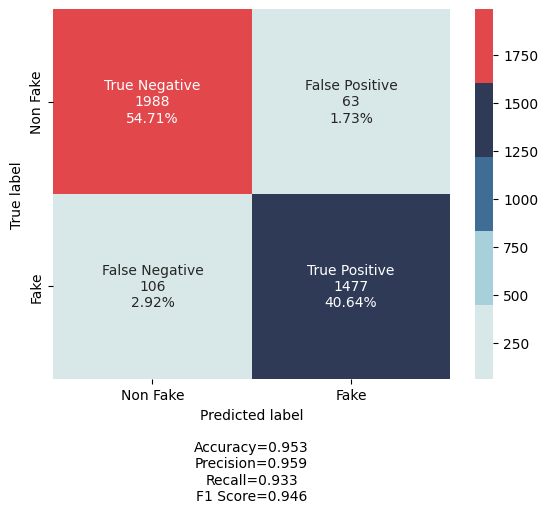

In [13]:
make_confusion_matrix(cm, 
                      group_names=['True Negative','False Positive','False Negative','True Positive'],
                      categories=['Non Fake', 'Fake'], 
                      cmap=ListedColormap(colors))

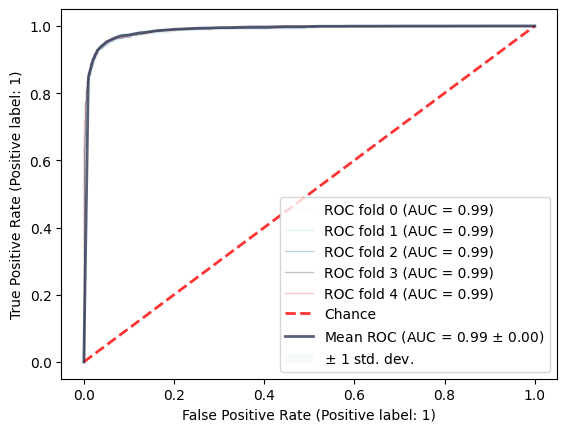

In [14]:
plot_roc_cv(pac)

## LogisticRegression

In [15]:
lr = LogisticRegression(max_iter = 500)
lr.fit(tfidf_train, y_train)

pred = lr.predict(tfidf_test)
cm = confusion_matrix(y_test, pred)

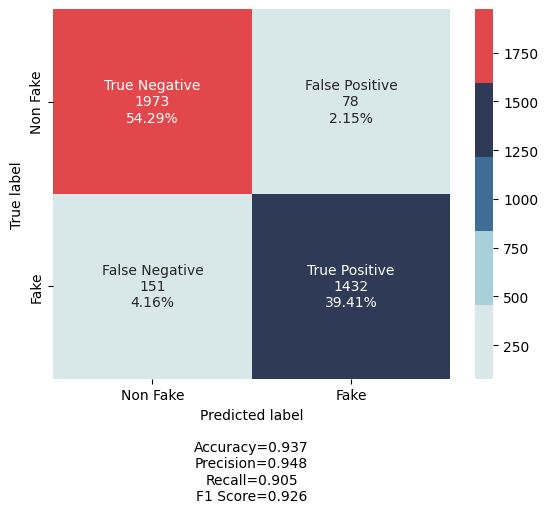

In [16]:
make_confusion_matrix(cm, 
                      group_names=['True Negative','False Positive','False Negative','True Positive'],
                      categories=['Non Fake', 'Fake'], 
                      cmap=ListedColormap(colors))

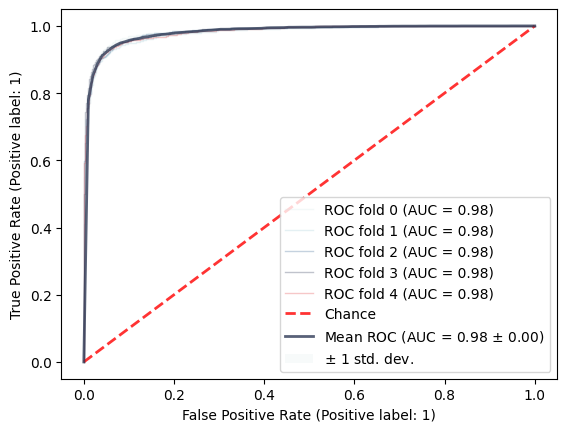

In [17]:
plot_roc_cv(lr)

## XGBClassifier

In [18]:
xgb = XGBClassifier()
xgb.fit(tfidf_train, y_train)

pred = xgb.predict(tfidf_test)
cm = confusion_matrix(y_test, pred)

/home/viti/.cache/pypoetry/virtualenvs/nlp-to8D2093-py3.10/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


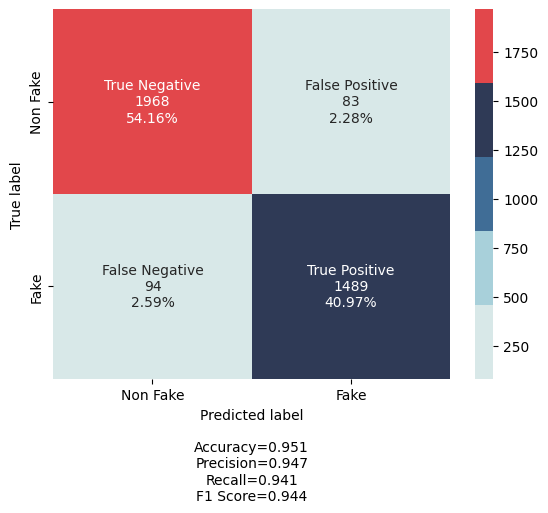

In [19]:
make_confusion_matrix(cm, 
                      group_names=['True Negative','False Positive','False Negative','True Positive'],
                      categories=['Non Fake', 'Fake'], 
                      cmap=ListedColormap(colors))

/home/viti/.cache/pypoetry/virtualenvs/nlp-to8D2093-py3.10/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/viti/.cache/pypoetry/virtualenvs/nlp-to8D2093-py3.10/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/viti/.cache/pypoetry/virtualenvs/nlp-to8D2093-py3.10/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/viti/.cache/pypoetry/virtualenvs/nlp-to8D2093-py3.10/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, 

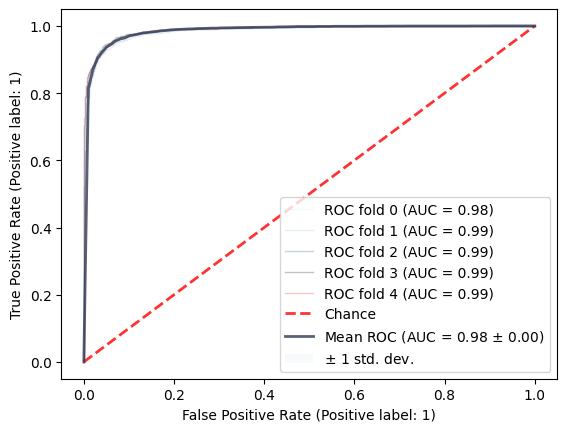

In [20]:
plot_roc_cv(xgb)

## LGBMClassifier

In [21]:
lgbm = LGBMClassifier()
lgbm.fit(tfidf_train, y_train)

pred = lgbm.predict(tfidf_test)
cm = confusion_matrix(y_test, pred)

[LightGBM] [Info] Number of positive: 6224, number of negative: 8309
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.653794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 867709
[LightGBM] [Info] Number of data points in the train set: 14533, number of used features: 16372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.428267 -> initscore=-0.288926
[LightGBM] [Info] Start training from score -0.288926


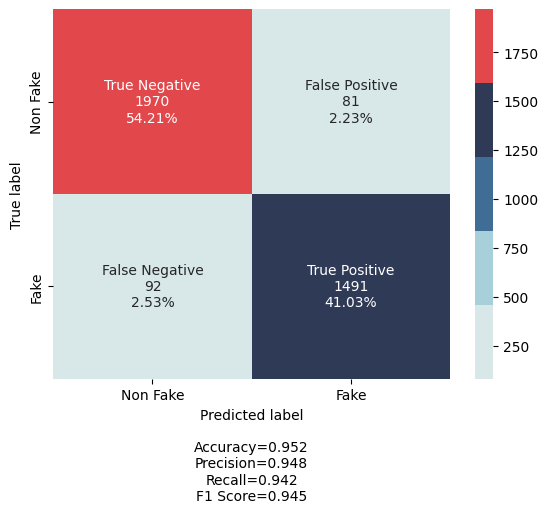

In [22]:
make_confusion_matrix(cm, 
                      group_names=['True Negative','False Positive','False Negative','True Positive'],
                      categories=['Non Fake', 'Fake'], 
                      cmap=ListedColormap(colors))

[LightGBM] [Info] Number of positive: 4977, number of negative: 6649
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.496572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 732429
[LightGBM] [Info] Number of data points in the train set: 11626, number of used features: 14445
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.428092 -> initscore=-0.289639
[LightGBM] [Info] Start training from score -0.289639
[LightGBM] [Info] Number of positive: 4965, number of negative: 6661
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.445138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 730030
[LightGBM] [Info] Number of data points in the train set: 11626, number of used features: 14383
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427060 -> initscore=-0.293

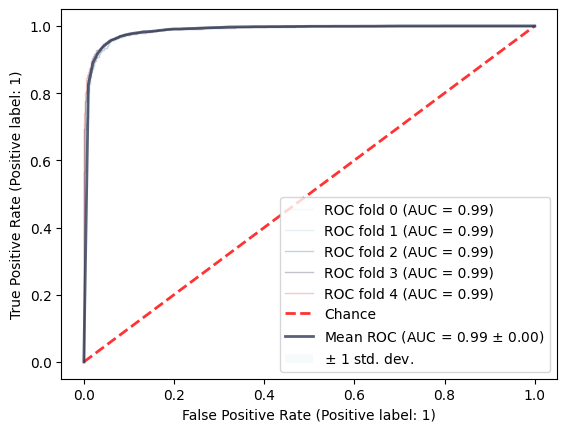

In [23]:
plot_roc_cv(lgbm)

# Title vs clean_text metrics

In [52]:
title_metrics = {
    'LogisticRegression': {
        'Accuracy': 0.917,
        'Precision': 0.854,
        'Recall': 0.977,
        'F1 Score': 0.912
    },
    'PassiveAggressiveClassifier': {
        'Accuracy': 0.933,
        'Precision': 0.911,
        'Recall': 0.937,
        'F1 Score': 0.924
    },
    'LGBMClassifier': {
        'Accuracy': 0.922,
        'Precision': 0.872,
        'Recall': 0.962,
        'F1 Score': 0.915
    },
    'XGBClassifier': {
        'Accuracy': 0.923,
        'Precision': 0.862,
        'Recall': 0.979,
        'F1 Score': 0.917
    }
}

In [53]:
df_title = pd.DataFrame.from_dict({(i, j): title_metrics[i][j] for i in title_metrics.keys() for j in title_metrics[i].keys()}, orient='index')
df_title.index = pd.MultiIndex.from_tuples(df.index, names=['Model', 'Metric'])
df_title.columns = ['Value']
df_title

Value
Model                       Metric          
LogisticRegression          Accuracy   0.917
                            Precision  0.854
                            Recall     0.977
                            F1 Score   0.912
PassiveAggressiveClassifier Accuracy   0.933
                            Precision  0.911
                            Recall     0.937
                            F1 Score   0.924
LGBMClassifier              Accuracy   0.922
                            Precision  0.872
                            Recall     0.962
                            F1 Score   0.915
XGBClassifier               Accuracy   0.923
                            Precision  0.862
                            Recall     0.979
                            F1 Score   0.917

In [54]:
clean_text_metrics = {
    'LogisticRegression': {
        'Accuracy': 0.937,
        'Precision': 0.948,
        'Recall': 0.905,
        'F1 Score': 0.926
    },
    'PassiveAggressiveClassifier': {
        'Accuracy': 0.953,
        'Precision': 0.959,
        'Recall': 0.933,
        'F1 Score': 0.946
    },
    'LGBMClassifier': {
        'Accuracy': 0.952,
        'Precision': 0.948,
        'Recall': 0.942,
        'F1 Score': 0.945
    },
    'XGBClassifier': {
        'Accuracy': 0.951,
        'Precision': 0.947,
        'Recall': 0.941,
        'F1 Score': 0.944
    }
}

In [55]:
df_clean_text = pd.DataFrame.from_dict({(i, j): clean_text_metrics[i][j] for i in clean_text_metrics.keys() for j in clean_text_metrics[i].keys()}, orient='index')
df_clean_text.index = pd.MultiIndex.from_tuples(df.index, names=['Model', 'Metric'])
df_clean_text.columns = ['Value']
df_clean_text

Value
Model                       Metric          
LogisticRegression          Accuracy   0.937
                            Precision  0.948
                            Recall     0.905
                            F1 Score   0.926
PassiveAggressiveClassifier Accuracy   0.953
                            Precision  0.959
                            Recall     0.933
                            F1 Score   0.946
LGBMClassifier              Accuracy   0.952
                            Precision  0.948
                            Recall     0.942
                            F1 Score   0.945
XGBClassifier               Accuracy   0.951
                            Precision  0.947
                            Recall     0.941
                            F1 Score   0.944

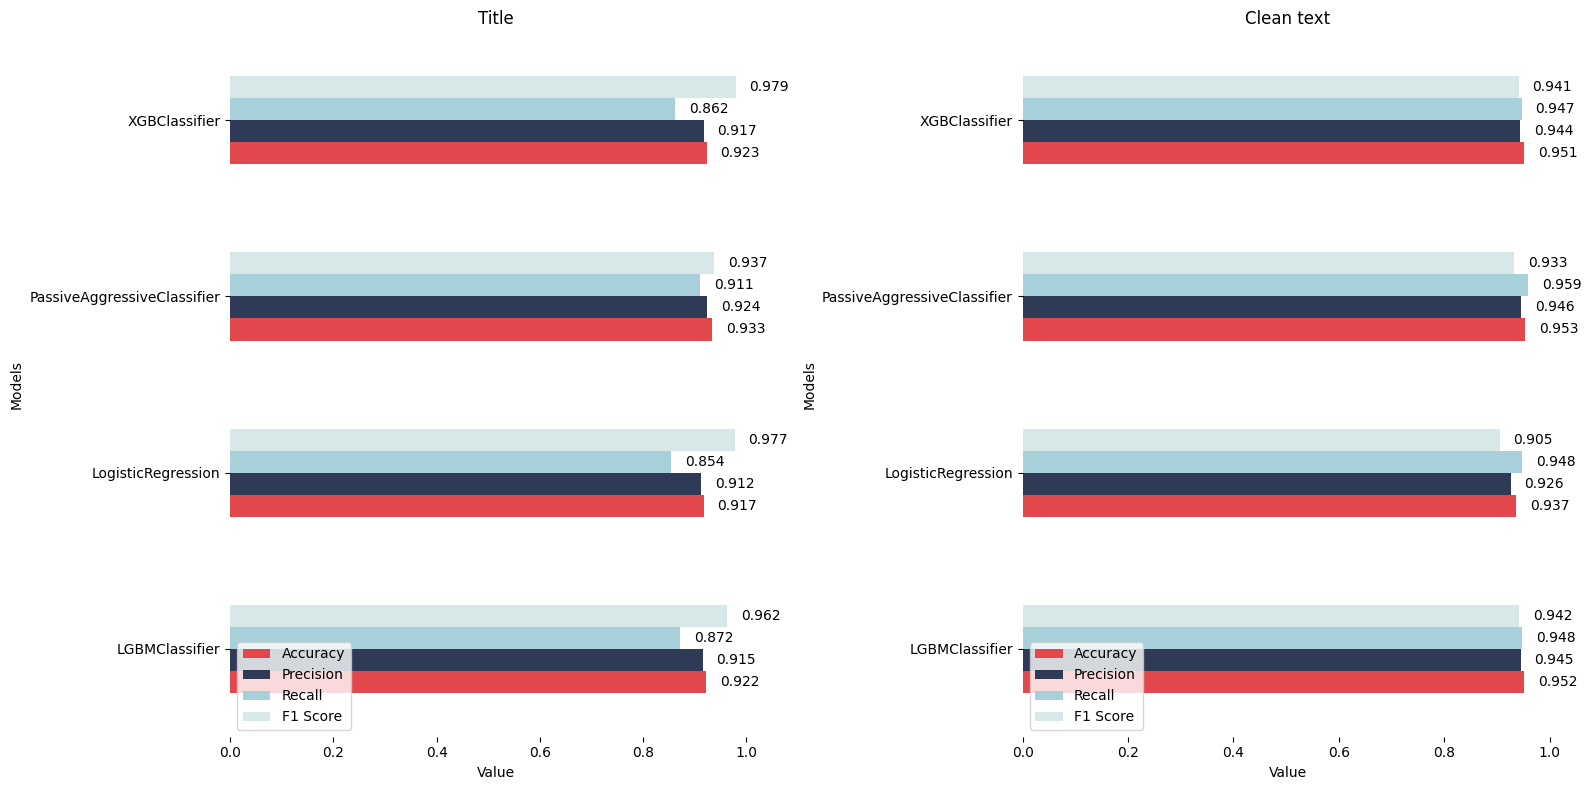

In [66]:
# Configurar el tamaño y diseño de los subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Primer subplot para el análisis de títulos
df_title_unstacked = df_title.unstack(level='Model')
df_title_unstacked.columns = df_title_unstacked.columns.droplevel()
df_title_unstacked = df_title_unstacked.transpose()
ax = df_title_unstacked.plot(kind='barh', stacked=False, colormap=ListedColormap(colors[::-1]), ax=axes[0])

for p in ax.patches:
    ax.annotate(f'{p.get_width():.3f}', (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='left', va='center', xytext=(10, 0), textcoords='offset points')



# Configurar el título y las etiquetas del primer subplot
axes[0].set_title('Title')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Models')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].legend(df_title.index.get_level_values(1).unique(), loc='lower left')

# Segundo subplot para el análisis de contenido
df_clean_text_unstacked = df_clean_text.unstack(level='Model')
df_clean_text_unstacked.columns = df_clean_text_unstacked.columns.droplevel()
df_clean_text_unstacked = df_clean_text_unstacked.transpose()
ax = df_clean_text_unstacked.plot(kind='barh', stacked=False, colormap=ListedColormap(colors[::-1]), ax=axes[1])

for p in ax.patches:
    ax.annotate(f'{p.get_width():.3f}', (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='left', va='center', xytext=(10, 0), textcoords='offset points')



# Configurar el título y las etiquetas del segundo subplot
axes[1].set_title('Clean text')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Models')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].legend(df_clean_text.index.get_level_values(1).unique(), loc='lower left')

# Ajustar el diseño para evitar solapamiento
plt.tight_layout()
# Mostrar los subplots
plt.show()